## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

<font color='blue'>**Load the data**</font>

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2021-10-31 07:17:37--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730753 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.37M  --.-KB/s    in 0.07s   

2021-10-31 07:17:37 (104 MB/s) - ‘ita-eng.zip’ saved [7730753/7730753]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-10-31 07:17:38--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-10-31 07:17:38--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb0b23f99393865d182aa3ca60.dl.dropboxusercontent.com/cd/0/inline/BZEZQXPG0uRzaOl-h1PM7czOzJG54GNQGIvklYMz4WJLhq9w6LUELJZf54WYIjgfbjlw9vfqerxQPAzzGebKE7NJ2IT1A1JXs2EBhdd_7BwhrrJLO_gRQO4x06q7zi1S4vlx7rKkkHD7LR5OGe0sMw4b/file# [following]
--2021-10-31 07:17:39--  https://uccb0b23f99393865d182aa3ca60.dl.dropboxusercontent.com/cd/0/inline/BZEZQXPG0uRzaOl-h1PM7czOzJG54GNQGIvklYMz4WJLhq9w6LUELJZf54WYIjgfbjlw9vfqerx

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(352040, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [ ]:
def decontractions(phrase):

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
219811,tom non si poteva permettere un avvocato,<start> tom could not afford a lawyer,tom could not afford a lawyer <end>
184138,vorrei che tom fosse ancora qui,<start> i wish tom were still here,i wish tom were still here <end>
183750,io voglio tom fuori da casa mia,<start> i want tom out of my house,i want tom out of my house <end>
223135,qual è lindirizzo attuale di tom,<start> what is tom is current address,what is tom is current address <end>
89867,io penso di piacere a tom,<start> i think tom likes me,i think tom likes me <end>
341242,perché non ci hai detto che questo stava per c...,<start> why did not you tell us this was going...,why did not you tell us this was going to happ...
106599,io sono troppo impegnata per questo,<start> i am too busy for this,i am too busy for this <end>
194141,saresti dovuta venire con noi,<start> you should have come with us,you should have come with us <end>
77168,tom è ancora celibe,<start> is tom still single,is tom still single <end>
170339,non dovrebbe capitare ancora,<start> it should not happen again,it should not happen again <end>


In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13023
26553


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10311)

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):


    def __init__(self,vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):

        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):

      return tf.zeros((batch_size,self.lstm_size)), tf.zeros((batch_size,self.lstm_size))
      


In [ ]:
class Decoder(tf.keras.Model):


    def __init__(self,vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length

        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True, name="Decoder_LSTM")
        

    def call(self,input_sequence,initial_states):

        target_embedd = self.embedding(input_sequence)
        lstm_output, final_state_h, final_state_c = self.lstm(target_embedd, initial_state=initial_states)
        return lstm_output, final_state_h, final_state_c 
      


In [ ]:

class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, vocab_size_ita, vocab_size_eng, embedding_size_ita, embedding_size_eng, encoder_inputs_length,decoder_inputs_length,  encoder_unit, decoder_unit,  output_vocab_size):

        super().__init__()
        self.encoder = Encoder(vocab_size = vocab_size_ita, embedding_size = embedding_size_ita, lstm_size = encoder_unit, input_length = encoder_inputs_length)
        self.decoder = Decoder(vocab_size = vocab_size_eng, embedding_size = embedding_size_eng, lstm_size = decoder_unit, input_length = decoder_inputs_length)
        self.dense   = Dense(output_vocab_size, activation='softmax')
    
    
    def call(self, data):

        input,output = data[0], data[1]
        #intialize states
        initial_states= self.encoder.initialize_states(32)
        encoder_output, encoder_h, encoder_c = self.encoder(input, initial_states)
        decoder_output, encoder_h, encoder_c = self.decoder(output, [encoder_h, encoder_c])
        output = self.dense(decoder_output)
        return output
        
        

In [ ]:
embedding_size_ita = 50
embedding_size_eng = 50
encoder_inputs_length = 30
decoder_inputs_length = 20
encoder_unit = 64
decoder_unit = 64
model = Encoder_decoder(vocab_size_ita, vocab_size_eng, embedding_size_ita, embedding_size_eng, encoder_inputs_length, decoder_inputs_length, encoder_unit, decoder_unit, vocab_size_eng )

In [ ]:
#data pipeline->
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): 
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)


train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
274/274 [==============================] - 60s 194ms/step - loss: 2.0566 - val_loss: 1.7978
Epoch 2/10
274/274 [==============================] - 51s 186ms/step - loss: 1.7215 - val_loss: 1.6392
Epoch 3/10
274/274 [==============================] - 51s 187ms/step - loss: 1.6008 - val_loss: 1.5515
Epoch 4/10
274/274 [==============================] - 51s 187ms/step - loss: 1.5069 - val_loss: 1.4436
Epoch 5/10
274/274 [==============================] - 51s 186ms/step - loss: 1.3888 - val_loss: 1.3263
Epoch 6/10
274/274 [==============================] - 51s 184ms/step - loss: 1.2695 - val_loss: 1.2131
Epoch 7/10
274/274 [==============================] - 51s 185ms/step - loss: 1.1693 - val_loss: 1.1308
Epoch 8/10
274/274 [==============================] - 51s 185ms/step - loss: 1.0914 - val_loss: 1.0634
Epoch 9/10
274/274 [==============================] - 51s 185ms/step - loss: 1.0216 - val_loss: 0.9984
Epoch 10/10
274/274 [==============================] - 51s 184ms/step - l

In [ ]:
def predict(input_sentence):

  #Given input sentence, convert the sentence into integers using tokenizer used earlier
  seq = tknizer_ita.texts_to_sequences([input_sentence]) 
  seq = pad_sequences(seq, maxlen=20, dtype='int32', padding='post')
  #Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  #encoder call->
  initial_states = model.layers[0].initialize_states(32)
  enc_outputs, enc_state_h , enc_state_c = model.layers[0](seq,initial_states)
  states_values = [enc_state_h, enc_state_c]
  #Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  #tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']
  start_index = tknizer_eng.word_index['<start>']
  words_li = []
  len_ = 20

  for i in range(len_):
    #predicted_out,state_h,state_c=model.layers[1](dec_input,states)
    dec_outputs, dec_state_h, dec_state_c = model.layers[1](np.expand_dims([start_index], 0), states_values)
    #pass the predicted_out to the dense layer
    dense_out = model.layers[2](dec_outputs)
    #update the states=[state_h,state_c]
    states_values = [dec_state_h, dec_state_c]
    #And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
    cur_index = np.reshape(np.argmax(dense_out),(1,1))
    start_index = cur_index
    word=tknizer_eng.sequences_to_texts(cur_index)
    words_li.append(word)
    if word==['<end>']:
      break

  return words_li


In [ ]:
pred_inp = list(data.loc[[4], 'italian'])
pred_out = predict(pred_inp)
print(pred_out)

[['do'], ['do'], ['<end>']]


In [ ]:
#https://datatofish.com/random-rows-pandas-dataframe/
vald_sample = validation.sample(1000)
vald_sample.head()

,italian,english_inp,english_out
296556,dica a tom che so dove abita,<start> tell tom that i know where he lives,tell tom that i know where he lives <end>
97929,cosa volete ora,<start> what do you want now,what do you want now <end>
183631,pensavo ci volessero mesi,<start> i thought it would take months,i thought it would take months <end>
80483,tom è un ragazzino stupido,<start> tom is a stupid boy,tom is a stupid boy <end>
339639,noi dobbiamo ottenere il maggior numero possib...,<start> we have to get as much information as ...,we have to get as much information as possible...


In [ ]:
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu

#https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column-or-row
inp_pred = vald_sample['italian'].tolist()
eng_sent = vald_sample['english_inp'].tolist()
blue_score = []
for i in range(len(vald_sample)):
  translation = predict(inp_pred[i])
  reference = [eng_sent[i].split(),]
  #reshaping the predicted sent.
  translation2 = []
  for i in range(len(translation)):
    translation2.append(translation[i][0])
  print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation2)))
  

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 0.3021375397356768
BLEU score: 0.5946035575013605
BLEU score: 0.5266403878479265
BLEU score: 0.537284965911771
BLEU score: 0.6262844962765469
BLEU score: 0.4728708045015879
BLEU score: 0.5623413251903491
BLEU score: 0.4924790605054523
BLEU score: 0.5081327481546147
BLEU score: 0.6147881529512643
BLEU score: 0.5623413251903491
BLEU score: 0.5623413251903491
BLEU score: 0.537284965911771
BLEU score: 0.36720562698935927
BLEU score: 0.668740304976422
BLEU score: 0
BLEU score: 0.5491004867761125
BLEU score: 0.5491004867761125
BLEU score: 0
BLEU score: 0.4854917717073234
BLEU score: 0.5623413251903491
BLEU score: 0.6389431042462724
BLEU score: 0.5081327481546147
BLEU score: 0.6147881529512643
BLEU score: 0.5475182535069453
BLEU score: 0.7071067811865476
BLEU score: 0.5695988432761473
BLEU score: 0.668740304976422
BLEU score: 0.33649324423301513
BLEU score: 0.4854917717073234
BLEU score: 0.7071067811865476
BLEU score: 0.3860973950960897
BLEU score: 0.5475182535069453
BLEU score: 0

## Task -2: Including Attention mechanisum

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self,vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):
      input_embedd = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
      return tf.zeros((batch_size,self.lstm_size)),tf.zeros((batch_size,self.lstm_size))
      


<font color='blue'>**Attention**</font>

In [ ]:
#Resource- https://www.youtube.com/watch?v=pLpzU-xGi2E
#https://www.tensorflow.org/text/tutorials/nmt_with_attention
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

    super().__init__()
    self.scoring_function=scoring_function

    if self.scoring_function=='dot':
      #Nothing is required to be learned
      pass
    if scoring_function == 'general':
      #He*W*Hd
      self.w_vect = Dense(att_units)
      pass
    elif scoring_function == 'concat':
      # tanh(He*W1 + Hd*W2)*V1
      self.W1 = Dense(att_units)
      self.W2 = Dense(att_units)
      self.V1 = Dense(1)
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):

    decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)

    if self.scoring_function == 'dot':
        # Dot score function here
        #score = np.dot(encoder_output, decoder_hidden_state.T)
        score = tf.linalg.matmul(encoder_output, decoder_hidden_state, transpose_b = True)
        pass
    elif self.scoring_function == 'general':
        # General score function here
        score = tf.linalg.matmul(self.w_vect(encoder_output), decoder_hidden_state, transpose_b = True)
        pass
    elif self.scoring_function == 'concat':
        # concat score function here
        score = self.V1(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))
        pass

    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum(attention_weights * encoder_output , axis=1)
    return context_vector, attention_weights
    

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
#https://www.youtube.com/watch?v=pLpzU-xGi2E
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      
      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units

      self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                                 name="embedding_layer_decoder")
      self.attention = Attention('dot',self.att_units)
      self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
      self.dense1 = Dense(self.tar_vocab_size)
      


  def call(self,input_to_decoder, encoder_output, state_h,state_c):

    inp_embd = self.embedding(input_to_decoder)    
    context_vector, attention_weights = self.attention(state_h, encoder_output)
    concat_layer = tf.concat([tf.expand_dims(context_vector, 1), inp_embd], axis=2)
    output_lstm, state_h, state_c = self.lstm(concat_layer, [state_h,state_c])
    output_lstm = tf.reshape(output_lstm,(-1, output_lstm.shape[2]))
    output_dense = self.dense1(output_lstm)
    #return attention_weights, context_vector, output_dense, state_h, state_c, 
    return output_dense, state_h, state_c, attention_weights, context_vector


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.onestepdecoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

        
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):

        all_outputs = tf.TensorArray(tf.float32, size = self.input_length, name = 'output_arrays')
        
        for timestamp in range(self.input_length):  
          output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.onestepdecoder(input_to_decoder[:,timestamp:timestamp+1], encoder_output, decoder_hidden_state, decoder_cell_state)
          all_outputs = all_outputs.write(timestamp , output)

        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])

        return all_outputs 

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, vocab_size, out_vocab_size, encoder_input_length, decoder_input_length, score_function, attention_units):
    #Intialize objects from encoder decoder
    super().__init__()
    self.encoder = Encoder(vocab_size, embedding_size= 100, lstm_size= 64, input_length= encoder_input_length)
    self.decoder = Decoder(out_vocab_size, embedding_dim= 100,  dec_units= 64, input_length= decoder_input_length, score_fun = score_function, att_units = attention_units)
    #self.batch_size = batch_size
  
  def call(self,data):
    input,output = data[0], data[1]
    initial_state = self.encoder.initialize_states(128)
    encoder_output , encoder_state_h , encoder_state_c = self.encoder(input, initial_state)
    decoder_output= self.decoder(output, encoder_output , encoder_state_h, encoder_state_c)
    return decoder_output

<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
dot_atten_model = encoder_decoder(vocab_size= vocab_size_ita, out_vocab_size= vocab_size_eng, encoder_input_length= 20, decoder_input_length= 20, score_function = 'dot', attention_units = 512)

<font color='blue'>**Training**</font>

Dot Function-

In [ ]:
dot_atten_model = encoder_decoder(vocab_size= vocab_size_ita, out_vocab_size= vocab_size_eng, encoder_input_length= 20, decoder_input_length= 20, score_function = 'dot', attention_units = 512)

In [ ]:
#data pipeline->
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)


train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
dot_atten_model.compile(optimizer= optimizer, loss = loss_function)

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
dot_atten_model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
274/274 [==============================] - 85s 213ms/step - loss: 2.0261 - val_loss: 1.7722
Epoch 2/10
274/274 [==============================] - 52s 189ms/step - loss: 1.7359 - val_loss: 1.6854
Epoch 3/10
274/274 [==============================] - 52s 188ms/step - loss: 1.6006 - val_loss: 1.5125
Epoch 4/10
274/274 [==============================] - 52s 191ms/step - loss: 1.4419 - val_loss: 1.3598
Epoch 5/10
274/274 [==============================] - 52s 190ms/step - loss: 1.2906 - val_loss: 1.2255
Epoch 6/10
274/274 [==============================] - 52s 190ms/step - loss: 1.1647 - val_loss: 1.1120
Epoch 7/10
274/274 [==============================] - 52s 190ms/step - loss: 1.0528 - val_loss: 1.0172
Epoch 8/10
274/274 [==============================] - 53s 193ms/step - loss: 0.9559 - val_loss: 0.9342
Epoch 9/10
274/274 [==============================] - 53s 191ms/step - loss: 0.8709 - val_loss: 0.8646
Epoch 10/10
274/274 [==============================] - 52s 191ms/step - l

## <font color='blue'>**Inference**</font>

<font color='blue'>**Attention weights**</font>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
def plot_attention(attention_weights, sentence , predicted):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention_weights, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence.split(' '), fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted.split(' '), fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  
  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.show() 

<font color='blue'>**Sentence translation**</font>

In [ ]:
def predict(input_sentence):

  #Given input sentence, convert the sentence into integers using tokenizer used earlier
  inp_seq = tknizer_ita.texts_to_sequences([input_sentence])
  inp_seq = pad_sequences(inp_seq , maxlen= 20 , padding = 'post')
  #Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  initial_state = dot_atten_model.layers[0].initialize_states(32)
  enc_output, enc_state_h, enc_state_c = dot_atten_model.layers[0](inp_seq, initial_state)
  #Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder
  #start_index = np.zeros((1, 1))
  #start_index = np.array(tknizer_eng.word_index['<start>'],)
  #start_index = np.array(tknizer_eng.word_index['<start>'],)
  cur_index= np.zeros((1,1))
  cur_index[0,0] = tknizer_eng.word_index['<start>'] ##https://colab.research.google.com/drive/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ#scrollTo=wZK2HGq74Hcz
  words_li = []
  atten_wt_li = []
  len_ = 20

  for i in range(len_):
    #predicted_out,state_h,state_c=model.layers[1](dec_input,states)
    dec_outputs, dec_state_h, dec_state_c, atten_wt, contx_vec = dot_atten_model.layers[1].onestepdecoder(cur_index , enc_output , enc_state_h, enc_state_c)
    #update the states=[state_h,state_c]
    enc_state_h = dec_state_h
    enc_state_c = dec_state_c
    #And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
    cur_index = np.reshape((np.argmax(dec_outputs)),(1,1))
    word=tknizer_eng.sequences_to_texts(cur_index)
    words_li.append(word)
    atten_wt_li.append(atten_wt)
    if word==['<end>']:
      break

  return words_li, atten_wt_li

In [ ]:
validation.head()

,italian,english_inp,english_out
22038,tom mangia molto,<start> tom eats a lot,tom eats a lot <end>
237524,perché ha comprato quegli occhiali,<start> why did you buy those glasses,why did you buy those glasses <end>
200655,vorrei non averti sposata,<start> i wish i had not married you,i wish i had not married you <end>
10433,tom era pallido,<start> tom was pale,tom was pale <end>
81630,tom voleva osservare,<start> tom wanted to watch,tom wanted to watch <end>


In [ ]:
pred_inp = str(validation._get_value(237524, 'italian'))
pred_inp

'perché ha comprato quegli occhiali'

In [ ]:
output, attention = predict(pred_inp)

In [ ]:
output

[['why'], ['did'], ['you'], ['live'], ['in'], ['the'], ['window'], ['<end>']]

In [ ]:
#Since axes.matshow() take (M,N) 2D input->
for i in range(len(attention)):
  attention[i] = tf.squeeze(attention[i] , axis= 2)

att_li = [[]] * len(attention)
for i in range(len(attention)):
  att_li[i] = np.array(attention[i][0])

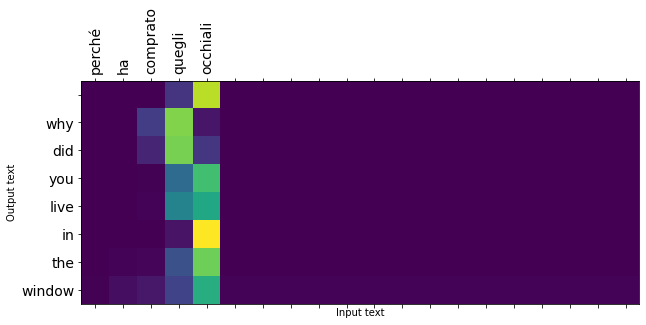

In [ ]:


def listToStringOut(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for i in range(len(s)):
        str1 = str1 +" " + s[i][0]  
    
    # return string  
    return str1 

pred_out = listToStringOut(output)
plot_attention(att_li, pred_inp, pred_out)

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
vald_sample = validation.sample(1000)
li = vald_sample.index.tolist()

In [ ]:

import nltk.translate.bleu_score as bleu
eng_sent = vald_sample['english_inp'].tolist()
blue_score = []
for i in range(len(vald_sample)):
  translation, atten_wt = predict(str(vald_sample._get_value(li[i], 'italian')))
  reference = [eng_sent[i].split(),]
  #reshaping the predicted sent.
  translation2 = []
  for i in range(len(translation)):
    translation2.append(translation[i][0])
  translation2 = [translation2]
  print('BLEU score: {}'.format(bleu.sentence_bleu(reference[0], translation2[0])))

BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.668740304976422
BLEU score: 0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 0
BLEU score: 0.537284965911771
BLEU score: 0
BLEU score: 0.6147881529512643
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.7071067811865476
BLEU score: 0.5773502691896257
BLEU score: 0
BLEU score: 0.5408536609893481
BLEU score: 0
BLEU score: 0
BLEU score: 0.6389431042462724
BLEU score: 0.6147881529512643
BLEU score: 0
BLEU score: 0
BLEU score: 0.5408536609893481
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.7071067811865476
BLEU score: 0
BLEU score: 0.6389431042462724
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0.5408536609893481
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0.6147881529512643
BLEU score: 0
BLEU score: 0
BLEU score: 0.7071067811865476
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.6389431042462724
BLEU score: 0
BLEU score: 0.6

<font color='blue'>**General scoring function**</font>

In [ ]:
general_atten_model = encoder_decoder(vocab_size= vocab_size_ita, out_vocab_size= vocab_size_eng, encoder_input_length= 20 , decoder_input_length= 20 , score_function = 'general', attention_units = 512)
opt = tf.keras.optimizers.Adam()
general_atten_model.compile(optimizer= opt, loss = loss_function)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
general_atten_model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
274/274 [==============================] - 85s 215ms/step - loss: 2.0083 - val_loss: 1.7393
Epoch 2/10
274/274 [==============================] - 52s 189ms/step - loss: 1.6977 - val_loss: 1.6212
Epoch 3/10
274/274 [==============================] - 52s 189ms/step - loss: 1.5367 - val_loss: 1.4528
Epoch 4/10
274/274 [==============================] - 52s 188ms/step - loss: 1.3911 - val_loss: 1.3236
Epoch 5/10
274/274 [==============================] - 52s 190ms/step - loss: 1.2648 - val_loss: 1.2089
Epoch 6/10
274/274 [==============================] - 52s 189ms/step - loss: 1.1558 - val_loss: 1.1179
Epoch 7/10
274/274 [==============================] - 52s 188ms/step - loss: 1.0605 - val_loss: 1.0302
Epoch 8/10
274/274 [==============================] - 52s 189ms/step - loss: 0.9713 - val_loss: 0.9555
Epoch 9/10
274/274 [==============================] - 52s 190ms/step - loss: 0.8928 - val_loss: 0.8908
Epoch 10/10
274/274 [==============================] - 52s 190ms/step - l

In [ ]:
def predict(input_sentence):

  #Given input sentence, convert the sentence into integers using tokenizer used earlier
  inp_seq = tknizer_ita.texts_to_sequences([input_sentence])
  inp_seq = pad_sequences(inp_seq , maxlen= 20 , padding = 'post')
  #Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  initial_state = general_atten_model.layers[0].initialize_states(32)
  enc_output, enc_state_h, enc_state_c = general_atten_model.layers[0](inp_seq, initial_state)
  #Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder
  cur_index= np.zeros((1,1))
  cur_index[0,0] = tknizer_eng.word_index['<start>'] 
  words_li = []
  atten_wt_li = []
  len_ = 20

  for i in range(len_):
    #predicted_out,state_h,state_c=model.layers[1](dec_input,states)
    dec_outputs, dec_state_h, dec_state_c, atten_wt, contx_vec = general_atten_model.layers[1].onestepdecoder(cur_index , enc_output , enc_state_h, enc_state_c)
    #update the states=[state_h,state_c]
    enc_state_h = dec_state_h
    enc_state_c = dec_state_c
    #And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
    cur_index = np.reshape((np.argmax(dec_outputs)),(1,1))
    word=tknizer_eng.sequences_to_texts(cur_index)
    words_li.append(word)
    atten_wt_li.append(atten_wt)
    if word==['<end>']:
      break

  return words_li, atten_wt_li

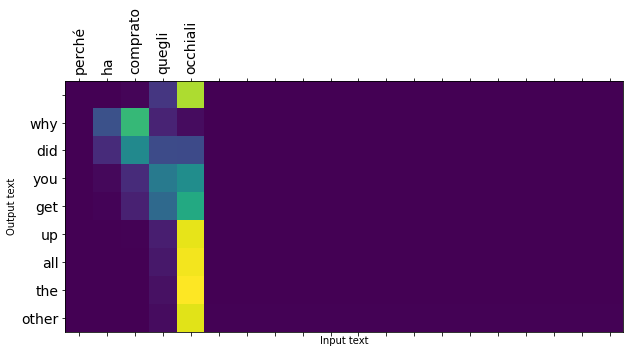

In [ ]:
pred_inp = str(validation._get_value(237524, 'italian'))

output, attention = predict(pred_inp)

#Since axes.matshow() take (M,N) 2D input->
for i in range(len(attention)):
  attention[i] = tf.squeeze(attention[i] , axis= 2)

att_li = [[]] * len(attention)
for i in range(len(attention)):
  att_li[i] = np.array(attention[i][0])

def listToStringOut(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for i in range(len(s)):
        str1 = str1 +" " + s[i][0]  
    
    # return string  
    return str1 

pred_out = listToStringOut(output)
plot_attention(att_li, pred_inp, pred_out)

In [ ]:
vald_sample = validation.sample(1000)
li = vald_sample.index.tolist()

eng_sent = vald_sample['english_inp'].tolist()
blue_score = []
for i in range(len(vald_sample)):
  translation, atten_wt = predict(str(vald_sample._get_value(li[i], 'italian')))
  reference = [eng_sent[i].split(),]
  #reshaping the predicted sent.
  translation2 = []
  for i in range(len(translation)):
    translation2.append(translation[i][0])
  translation2 = [translation2]
  print('BLEU score: {}'.format(bleu.sentence_bleu(reference[0], translation2[0])))

BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.6389431042462724


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 0
BLEU score: 0.5169731539571706
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0
BLEU score: 0.5169731539571706
BLEU score: 0
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.7071067811865476
BLEU score: 0.668740304976422
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.5408536609893481
BLEU score: 0.5946035575013605
BLEU score: 0.5623413251903491
BLEU score: 0
BLEU score: 0
BLEU score: 0.668740304976422
BLEU score: 0
BLEU score: 0.5773502691896257
BLEU score: 0
BLEU score: 0
BLEU score: 0.6389431042462724
BLEU score: 0
BLEU score: 0
BLEU score: 0.5946035575013605
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0.6147881529512643
BLEU score: 0.5946035575013605
BLEU score: 0.5623413251903491
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU sc

<font color='blue'>**Concat function-**</font>

In [ ]:
concat_atten_model = encoder_decoder(vocab_size= vocab_size_ita, out_vocab_size= vocab_size_eng, encoder_input_length= 20 , decoder_input_length= 20 , score_function = 'concat', attention_units = 512)
opt = tf.keras.optimizers.Adam()
concat_atten_model.compile(optimizer= opt, loss = loss_function)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
concat_atten_model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
274/274 [==============================] - 86s 217ms/step - loss: 2.0348 - val_loss: 1.7860
Epoch 2/10
274/274 [==============================] - 52s 189ms/step - loss: 1.7513 - val_loss: 1.6714
Epoch 3/10
274/274 [==============================] - 52s 189ms/step - loss: 1.6076 - val_loss: 1.5455
Epoch 4/10
274/274 [==============================] - 52s 190ms/step - loss: 1.4876 - val_loss: 1.4144
Epoch 5/10
274/274 [==============================] - 52s 190ms/step - loss: 1.3436 - val_loss: 1.2689
Epoch 6/10
274/274 [==============================] - 53s 192ms/step - loss: 1.1969 - val_loss: 1.1351
Epoch 7/10
274/274 [==============================] - 52s 190ms/step - loss: 1.0748 - val_loss: 1.0345
Epoch 8/10
274/274 [==============================] - 52s 191ms/step - loss: 0.9777 - val_loss: 0.9543
Epoch 9/10
274/274 [==============================] - 52s 189ms/step - loss: 0.8951 - val_loss: 0.8857
Epoch 10/10
274/274 [==============================] - 52s 189ms/step - l

In [ ]:
def predict(input_sentence):

  #Given input sentence, convert the sentence into integers using tokenizer used earlier
  inp_seq = tknizer_ita.texts_to_sequences([input_sentence])
  inp_seq = pad_sequences(inp_seq , maxlen= 20 , padding = 'post')
  #Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  initial_state = concat_atten_model.layers[0].initialize_states(32)
  enc_output, enc_state_h, enc_state_c = concat_atten_model.layers[0](inp_seq, initial_state)
  #Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder
  cur_index= np.zeros((1,1))
  cur_index[0,0] = tknizer_eng.word_index['<start>'] 
  words_li = []
  atten_wt_li = []
  len_ = 20

  for i in range(len_):
    #predicted_out,state_h,state_c=model.layers[1](dec_input,states)
    dec_outputs, dec_state_h, dec_state_c, atten_wt, contx_vec = concat_atten_model.layers[1].onestepdecoder(cur_index , enc_output , enc_state_h, enc_state_c)
    #update the states=[state_h,state_c]
    enc_state_h = dec_state_h
    enc_state_c = dec_state_c
    #And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
    cur_index = np.reshape((np.argmax(dec_outputs)),(1,1))
    word=tknizer_eng.sequences_to_texts(cur_index)
    words_li.append(word)
    atten_wt_li.append(atten_wt)
    if word==['<end>']:
      break

  return words_li, atten_wt_li

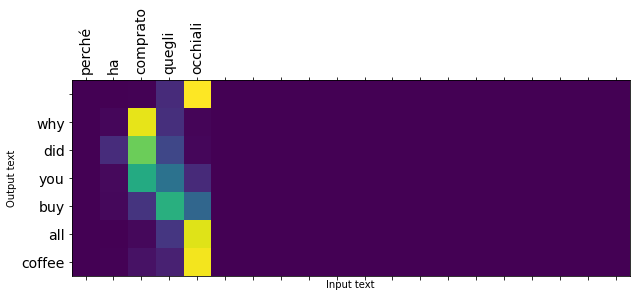

In [ ]:
pred_inp = str(validation._get_value(237524, 'italian'))

output, attention = predict(pred_inp)

#Since axes.matshow() take (M,N) 2D input->
for i in range(len(attention)):
  attention[i] = tf.squeeze(attention[i] , axis= 2)

att_li = [[]] * len(attention)
for i in range(len(attention)):
  att_li[i] = np.array(attention[i][0])
  

def listToStringOut(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for i in range(len(s)):
        str1 = str1 +" " + s[i][0]  
    
    # return string  
    return str1 

pred_out = listToStringOut(output)
plot_attention(att_li, pred_inp, pred_out)

In [ ]:
vald_sample = validation.sample(1000)
li = vald_sample.index.tolist()

eng_sent = vald_sample['english_inp'].tolist()
blue_score = []
for i in range(len(vald_sample)):
  translation, atten_wt = predict(str(vald_sample._get_value(li[i], 'italian')))
  reference = [eng_sent[i].split(),]
  #reshaping the predicted sent.
  translation2 = []
  for i in range(len(translation)):
    translation2.append(translation[i][0])
  translation2 = [translation2]
  print('BLEU score: {}'.format(bleu.sentence_bleu(reference[0], translation2[0])))

BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.6147881529512643


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0
BLEU score: 0.668740304976422
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.6147881529512643
BLEU score: 0.7071067811865476
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.6147881529512643
BLEU score: 0.7598356856515925
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.5475182535069453
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.668740304976422
BLEU score: 0.5946035575013605
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.5623413251903491
BLEU score: 0.6389431042462724
BLEU score: 0
BLEU score: 0.7311104457090247
BLEU score: 0.5491004867761125
BLEU score: 0.5773502691896257
BLEU score: 0.5773502691896257
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0
BLEU score: 0.668740304976422
BLEU score: 0.5408536609893481
BLEU score: 0
BLEU score: 0
BLEU score: 0.59460355750